In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Load

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Transfer into dataframe

In [3]:
train = pd.DataFrame(data=x_train.reshape(60000,784))
train['label'] = y_train.reshape(60000,)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.DataFrame(data=x_test.reshape(10000,784))
test['label'] = y_test.reshape(10000,)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,3,0,3,174,189,67,0,0,0,2
2,0,0,0,0,0,0,0,0,1,0,...,58,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,2,0,1,1,0,0,0,...,12,0,0,0,0,0,0,0,0,6


# Verify

### Label information:
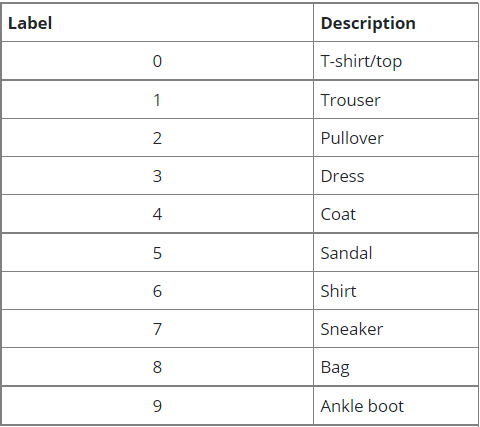

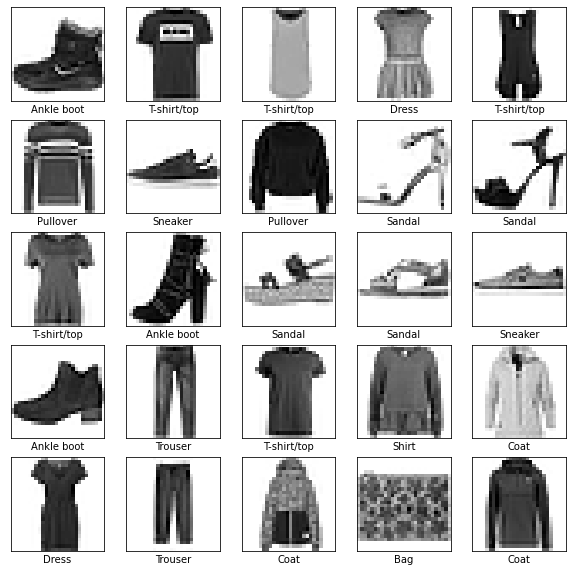

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

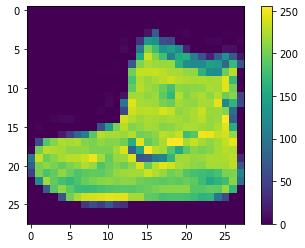

In [6]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
assert train.isnull().sum().all() == 0
assert test.isnull().sum().all() == 0
assert len(train) == 60000
assert len(test) == 10000

# Models

### First, we will fit some "weak" learners:

In [8]:
x_train = x_train.reshape(60000,784)
y_train = y_train.reshape(60000,)
x_test = x_test.reshape(10000,784)
y_test = y_test.reshape(10000,)

In [9]:
# KNN
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 0.0020492076873779297 seconds


In [10]:
# Decision Tree
start = time.time()
dct = DecisionTreeClassifier(random_state=0)
dct.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 25.3703293800354 seconds


In [11]:
# Logistic Regression
start = time.time()
logreg = LogisticRegression(solver='saga',max_iter=100, n_jobs=-1)
logreg.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 169.59312200546265 seconds


### Second, we will fit ensemble models:

In [12]:
# Random Forest
start = time.time()
rnd = RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
rnd.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 18.88130784034729 seconds


In [13]:
# Voting
start = time.time()
hard_voting = VotingClassifier(voting='hard', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
hard_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 186.3134891986847 seconds


In [14]:
# Voting
start = time.time()
soft_voting = VotingClassifier(voting='soft', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
soft_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 187.74429965019226 seconds


In [71]:
# Stacking 
start = time.time()
stacking = StackingClassifier(estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)])
stacking.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 1474.833091020584 seconds


In [ ]:
start = time.time()
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking]:
    print(model.__class__.__name__,"    ", model.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

### Last but not least, Boosting:

In [16]:
# Adaboost
start = time.time()
adaboost = AdaBoostClassifier(n_estimators=100, base_estimator=rnd)
adaboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 21.133264303207397 seconds


In [17]:
start = time.time() # Delete later
print(adaboost.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

0.8764
runtime: 0.1632826328277588 seconds


In [19]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss')
xgboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 238.06645369529724 seconds


In [20]:
start = time.time() # Delete later
print(xgboost.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

0.8983
runtime: 0.06975913047790527 seconds


In [ ]:
start = time.time()
#for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, xgboost]:
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, adaboost, xgboost]:
    print(model.__class__.__name__,"    ", model.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

### Since XGBoost provides the best accuracy, lets use Grid Search to have even better accuracy:

In [63]:
# Grid Search
start = time.time()
param_grid = [{'n_estimators': [50, 100, 150], 'learning_rate':[0.5, 1, 1.5]}]
model = XGBClassifier(eval_metric='mlogloss')
grid_search = GridSearchCV(model, param_grid, cv=[(slice(None), slice(None))], scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 2154.789169549942 seconds


In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.18524758208048672 {'learning_rate': 0.5, 'n_estimators': 50}
-0.0 {'learning_rate': 0.5, 'n_estimators': 100}
-0.0 {'learning_rate': 0.5, 'n_estimators': 150}
-0.0 {'learning_rate': 1, 'n_estimators': 50}
-0.0 {'learning_rate': 1, 'n_estimators': 100}
-0.0 {'learning_rate': 1, 'n_estimators': 150}
0.6245932009449564 {'learning_rate': 1.5, 'n_estimators': 50}
0.2660513734851473 {'learning_rate': 1.5, 'n_estimators': 100}
0.08266397845091497 {'learning_rate': 1.5, 'n_estimators': 150}


### Since theres a trade off between the two,  
### We must determine which combination of `learning_rate` and `n_estimators` gives the best accuracy:

In [70]:
#XGBoost
start = time.time()
for i in [0.5,1]:
    for j in [50,100,150]:
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j)
        xgboost.fit(x_train, y_train)
        print('learning_rate:',i,', n_estimators:',j,'-',xgboost.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 0.5 , n_estimators: 50 - 0.8881
learning_rate: 0.5 , n_estimators: 100 - 0.8979
learning_rate: 0.5 , n_estimators: 150 - 0.9
learning_rate: 1 , n_estimators: 50 - 0.8848
learning_rate: 1 , n_estimators: 100 - 0.8909
learning_rate: 1 , n_estimators: 150 - 0.8943
runtime: 1416.4611117839813 seconds


In [18]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=0.5, n_estimators=150, n_jobs=-1)
xgboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 393.897567987442 seconds


In [19]:
start = time.time()
#for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, xgboost]:
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, adaboost, xgboost]:
    print(model.__class__.__name__,"    ", model.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

KNeighborsClassifier      0.8554
DecisionTreeClassifier      0.7901
LogisticRegression      0.8414
RandomForestClassifier      0.8781
VotingClassifier      0.88
VotingClassifier      0.8698
AdaBoostClassifier      0.8764
XGBClassifier      0.9
runtime: 48.58997917175293 seconds


### XGBoost is the best model with 89-90% accuracy.  
### Now lets use dimensionality reduction and try to achieve the highest accuracy possible.

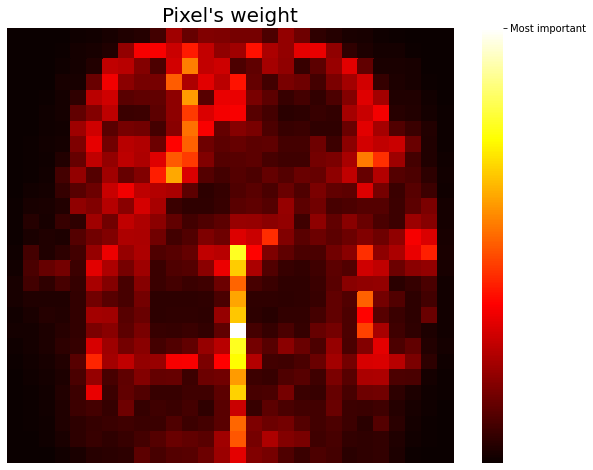

In [113]:
weight = rnd.feature_importances_
pixels = np.array(weight).reshape(28,28)
plt.figure(figsize= (10,8))
plot = sns.heatmap(pixels,cmap=plt.cm.hot)
plt.xticks([])
plot.set_yticks([])
colorbar = plot.collections[0].colorbar
colorbar.set_ticks([0,max(weight)])
colorbar.set_ticklabels(['Least important','Most important'])
plt.title('Pixel\'s weight',size = 20)
plt.show()

In [114]:
print("The most important pixel is:",np.argmax(weight == max(weight)))

The most important pixel is: 546


In [115]:
start = time.time()
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 3.241544008255005 seconds


Text(0, 0.5, 'variance preserved')

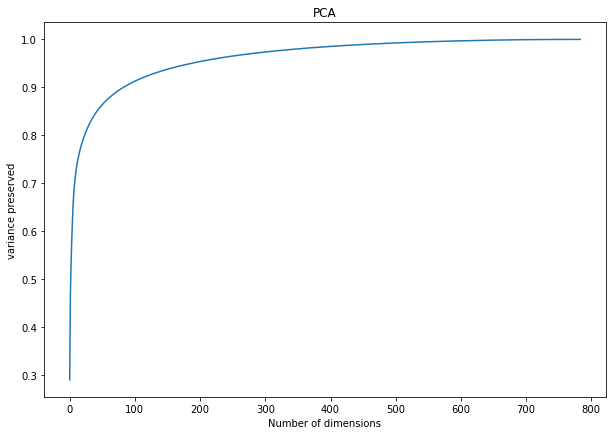

In [116]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.plot(cumsum)
plt.title('PCA')
plt.xlabel('Number of dimensions')
plt.ylabel('variance preserved')

### We will use the number of dimensions that preserve 95% of the variance:

In [117]:
print('number of dimensions:',np.argmax(cumsum >= 0.95))

number of dimensions: 186


In [118]:
pca = PCA(n_components=0.95)
x1_reduced = pca.fit_transform(x_train)
x2_reduced = pca.transform(x_test)

### In order to spare cells, we will fit them all in one:

In [107]:
start = time.time()
#for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, xgboost]:
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, adaboost, xgboost]:
    model.fit(x1_reduced,y_train)
    print(model.__class__.__name__,"     finished")
end = time.time()
print('runtime:',end - start, 'seconds')

KNeighborsClassifier      finished
DecisionTreeClassifier      finished
LogisticRegression      finished
RandomForestClassifier      finished
VotingClassifier      finished
VotingClassifier      finished
AdaBoostClassifier      finished
XGBClassifier      finished
runtime: 1062.991234779358 seconds


In [123]:
start = time.time()
#for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, xgboost]:
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, adaboost, xgboost]:
    print(model.__class__.__name__,"    ", model.score(x2_reduced,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

KNeighborsClassifier      0.8623
DecisionTreeClassifier      0.7565
LogisticRegression      0.8411
RandomForestClassifier      0.8593
VotingClassifier      0.8662
VotingClassifier      0.8557
AdaBoostClassifier      0.8585
XGBClassifier      0.8816
runtime: 30.468470811843872 seconds


### Using Grid Search is very time consuming, so we'll do this instead:

In [131]:
start = time.time()
for i, j in zip([1.5,1,0.5],[50,100,150]):
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j)
        xgboost.fit(x1_reduced, y_train)
        print('learning_rate:',i,', n_estimators:',j,'-',xgboost.score(x2_reduced,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 1.5 , n_estimators: 50 - 0.8171
learning_rate: 1 , n_estimators: 100 - 0.8736
learning_rate: 0.5 , n_estimators: 150 - 0.8816
runtime: 920.6477580070496 seconds


In [124]:
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=0.5, n_estimators=150)
xgboost.fit(x1_reduced, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 459.4781575202942 seconds


In [125]:
start = time.time()
print(xgboost.score(x2_reduced,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

0.8816
runtime: 0.06378507614135742 seconds


### Although we lost about 2% accuracy, given the fact that we gave up on 598 features, it seems like a good trade.